In [1]:
# generic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# notebook settings
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2 
# precision and plot settings
num_precision = 3
np.set_printoptions(precision=num_precision, suppress=True)
pd.set_option('display.float_format', lambda x: f'{x:,.{num_precision}f}')
pd.set_option("display.precision", num_precision)
pd.set_option('display.max_columns', None)
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# setup dir and import helper functions
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import helper_funcs as my_funcs

In [4]:
directory = '../data/sat_images/wild_est/'

In [5]:
batch_size = 64
img_size = 256

In [57]:
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, # maybe need: label_mode='binary' and rename directories to 0 1
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    validation_split=0.2, subset='training', interpolation='bilinear', follow_links=True
)
# this batch size is how it divides the data in the epochs below

Found 16232 files belonging to 2 classes.
Using 12986 files for training.


In [69]:
directory = '../data/sat_images/wild_est_test'

In [72]:
# make a dataset of 2
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, # maybe need: label_mode='binary' and rename directories to 0 1
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    interpolation='bilinear', follow_links=True
)

Found 2 files belonging to 2 classes.


In [7]:
X_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, # # maybe need: label_mode='binary' and rename directories to 0 1
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42, # maybe not need shuffle
    validation_split=0.2, subset='validation', interpolation='bilinear', follow_links=True
)

Found 16232 files belonging to 2 classes.
Using 3246 files for validation.


In [8]:
# plt.rcParams['font.size'] = 14
# my_funcs.plot_example_imgs(X_train, figsize=(15, 8), num_samples=10);

In [ ]:
# put into X and y
# image_batch, labels_batch = next(iter(X_train))

In [8]:
from skimage.filters import sobel
from skimage.feature import canny
from skimage.color import rgb2gray

In [9]:
def sobel_image(image):
    '''
    test with an image
    if it works change this to iterate through whole ds
    using skimage edge magnitude is computed:
    sobel_mag = np.sqrt(sum([sobel(image, axis=i)**2
                         for i in range(image.ndim)]) / image.ndim)
    '''
    image = image[0]
    image_sobeled = sobel(image)
    return image_sobeled

In [10]:
test_sobel = sobel_image(image_batch)

NameError: name 'image_batch' is not defined

In [ ]:
plt.imshow(test_sobel.astype('uint8'));

In [ ]:
plt.imshow(image_batch[0].numpy().astype('uint8'));

In [ ]:
# test canny - but can only work greyscale?
def canny_image(image, sigma=3):
    '''
    test with an image
    '''
    image = image[0]
    image_grey = rgb2gray(image)
    image_canny = canny(image_grey, sigma=sigma)
    return image_canny

In [ ]:
test_canny = canny_image(image_batch, sigma=1)

In [ ]:
plt.imshow(test_canny.astype('uint8'));

In [16]:
# test a more nuanced version
from scipy import ndimage

def sobel_image_adv(image):
    '''
    test with an image
    '''
    image = image[0]
    image_test = ndimage.sobel(image) # generic
    dx = ndimage.sobel(image, 0)  # horizontal derivative
    dy = ndimage.sobel(image, 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize (Q&D)
    image_sobeled_adv = mag
    return image_sobeled_adv

In [ ]:
test_sobel_adv = sobel_image_adv(image_batch)
# plt.imshow(test_sobel_adv)
plt.imshow(test_sobel_adv.astype('uint8'));

In [ ]:
test_sobel_adv = sobel_image_adv(image_batch)
# plt.imshow(test_sobel_adv)
plt.imshow(test_sobel_adv.astype('uint8'));

In [229]:
# test a more nuanced version
from scipy import ndimage

def sobel_image_adv_ds(image, filter_type=None):
    '''
    test with an image dataset
    '''
    #     filter_type = 'one_channel'
    #     if filter_type == 'one_channel':
    #         return ndimage.sobel(image) # generic
    dx = ndimage.sobel(image, 0)  # horizontal derivative
    dy = ndimage.sobel(image, 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize (Q&D)
    image_sobeled_adv = mag
    return image_sobeled_adv

In [230]:
from tensorflow import py_function, float32
def sobel_image_adv_batch(image, label):
    '''
    '''
    # define things for tf dataset
    im_shape = image.shape
    [image,] = py_function(sobel_image_adv_ds, [image], [float32])
    image.set_shape(im_shape)
    return image, label

In [231]:
X_train

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [232]:
# apply to entire dataset
X_train_sobel_ds = X_train.map(sobel_image_adv_batch)

In [233]:
X_train_sobel_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [234]:
# get one image
image_batch_sobel, labels_batch_sobel = next(iter(X_train_sobel_ds))

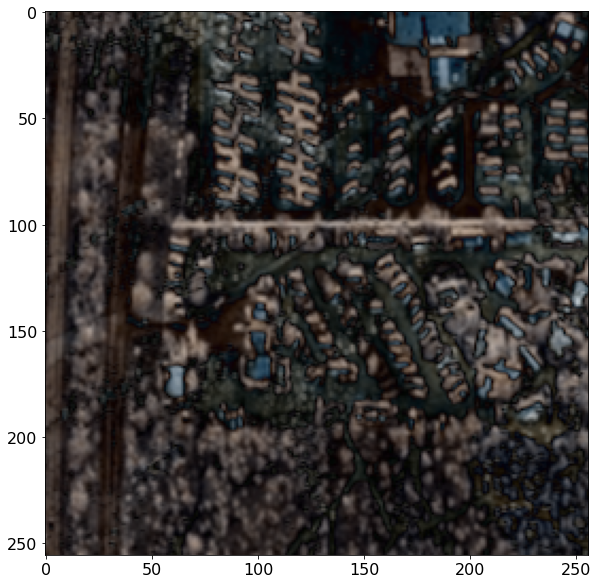

In [235]:
# but this sobel on all three channels
fig, ax = plt.subplots(1, figsize=(10,10))
plt.imshow(image_batch_sobel[0].numpy().astype('uint8'), cmap='Greys');

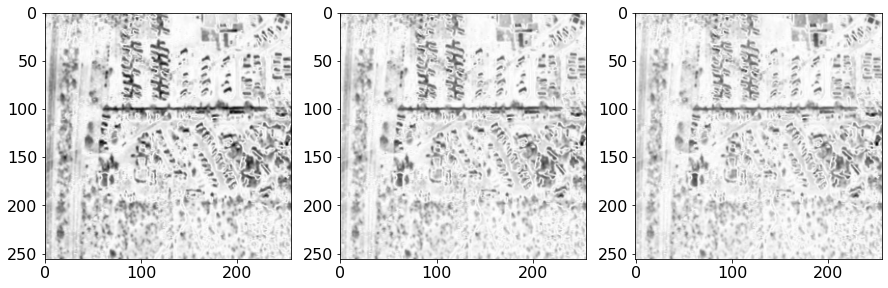

In [173]:
# each channel separate - you can slice into tensor just like numpy
fig, axs = plt.subplots(1, 3, figsize=(15,8))
axs[0].imshow(image_batch_sobel[0][:,:,0], cmap='Greys')
axs[1].imshow(image_batch_sobel[0][:,:,1], cmap='Greys')
axs[2].imshow(image_batch_sobel[0][:,:,2], cmap='Greys')

In [156]:
# get original image
image_batch, labels_batch = next(iter(X_train))

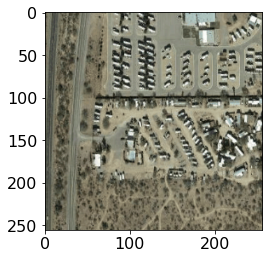

In [157]:
plt.imshow(image_batch[0].numpy().astype('uint8'))

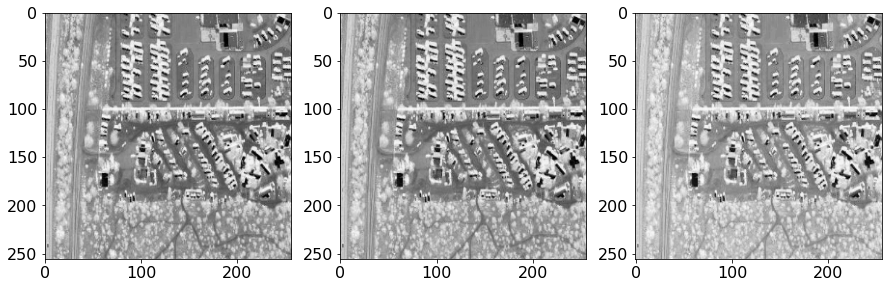

In [174]:
# each channel separate - you can slice into tensor just like numpy
fig, axs = plt.subplots(1, 3, figsize=(15,8))
axs[0].imshow(image_batch[0][:,:,0].numpy(), cmap='Greys')
axs[1].imshow(image_batch[0][:,:,1].numpy(), cmap='Greys')
axs[2].imshow(image_batch[0][:,:,2].numpy(), cmap='Greys')

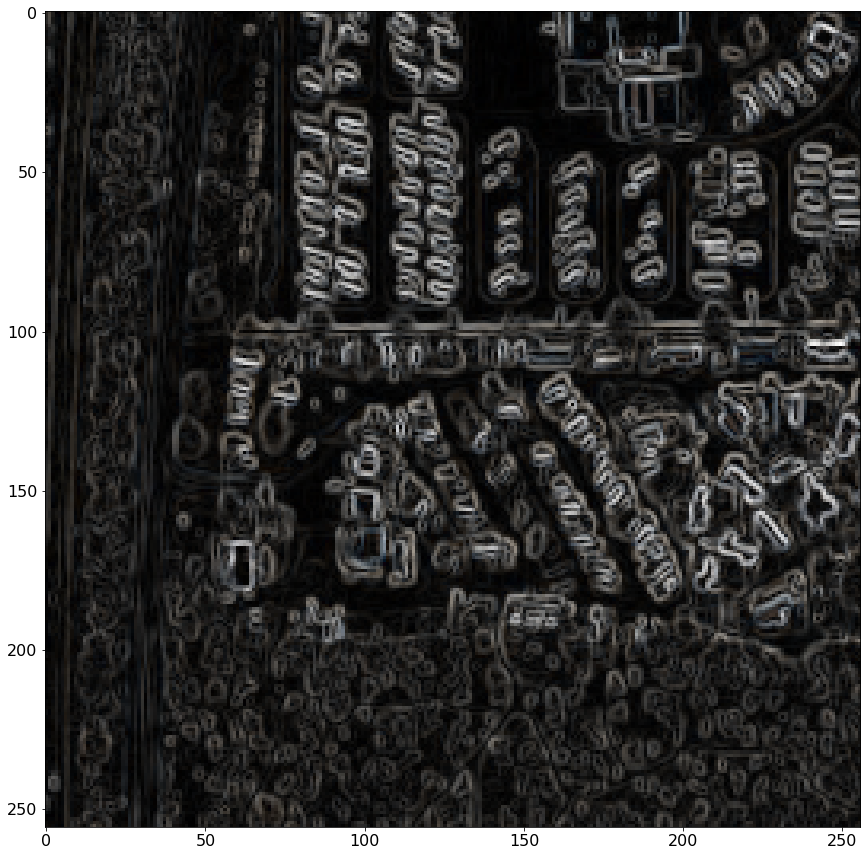

In [179]:
# test raw sobel transform, again all 3 channels
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(sobel_image_adv_ds(image_batch[0]).astype('uint8'))

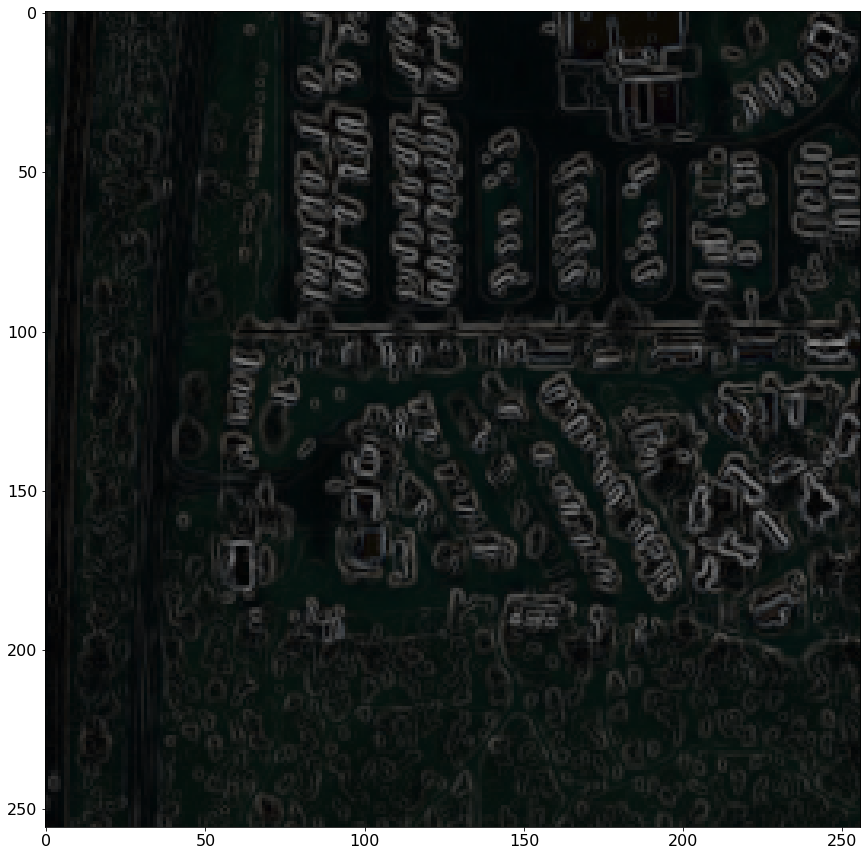

In [238]:
# test skimage sobel
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(sobel_image(image_batch).astype('uint8'))

In [395]:
# try again with tf sobel_edges
from tensorflow.image import sobel_edges
from tensorflow.math import reduce_sum
from tensorflow import sqrt

def tf_sobel(image):
    '''
    test with an image dataset
    '''
    grad_components = sobel_edges(image)
    grad_mag_components = grad_components**2
    grad_mag_square = reduce_sum(grad_mag_components,axis=-1) # sum all magnitude components
    grad_mag_img = sqrt(grad_mag_square) # this is the image tensor you want
#         dx = ndimage.sobel(image, 0)  # horizontal derivative
#     dy = ndimage.sobel(image, 1)  # vertical derivative
#     mag = np.hypot(dx, dy)  # magnitude
    grad_mag_img *= 255.0 / np.max(grad_mag_img)  # normalize (Q&D)
    return grad_mag_img

In [396]:
test = tf_sobel(image_batch)

In [397]:
image_batch.shape

TensorShape([2, 256, 256, 3])

In [398]:
test.shape

TensorShape([2, 256, 256, 3])

In [400]:
test_img = test[0]

In [389]:
test_img *= 255.0 / np.max(test_img)  # normalize (Q&D)

In [401]:
test_img.shape

TensorShape([256, 256, 3])

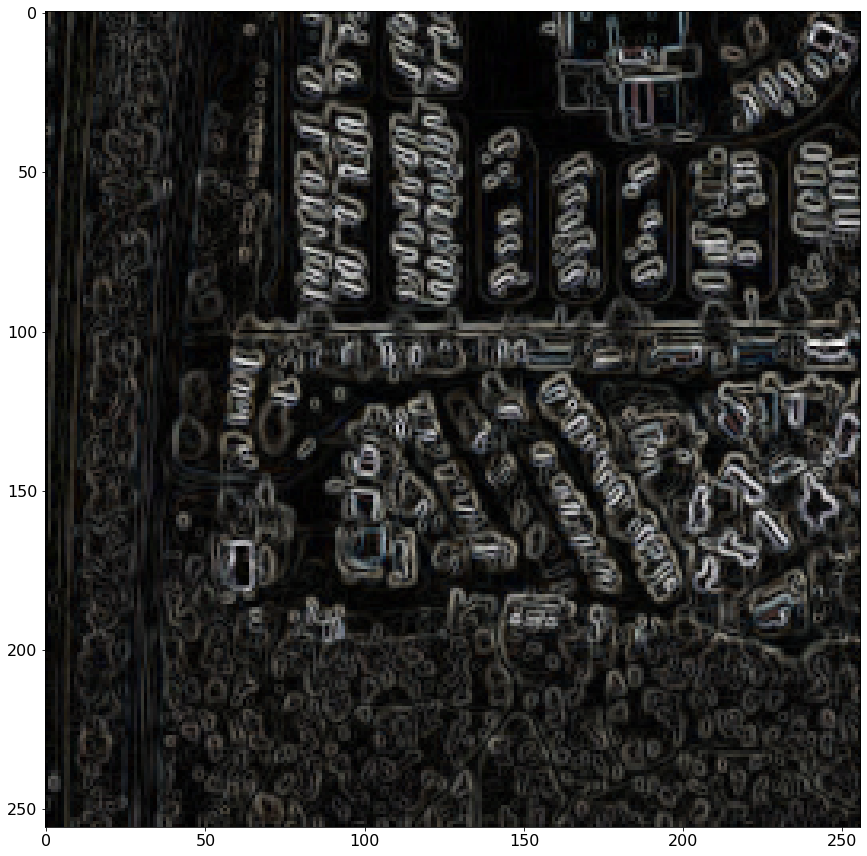

In [403]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(test_img.numpy().astype('uint8'), cmap='Greys')

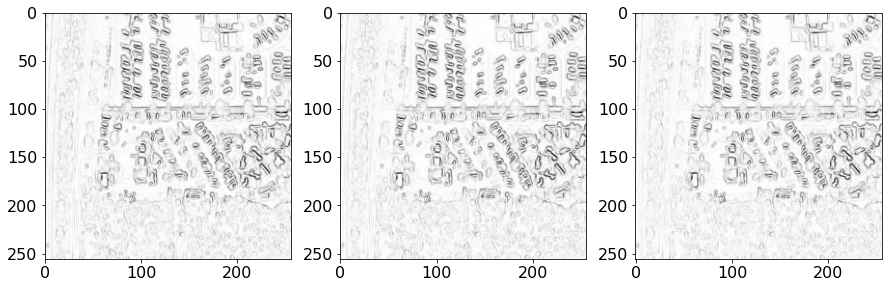

In [405]:
#tf_sobel
fig, axs = plt.subplots(1, 3, figsize=(15,8))
axs[0].imshow(test[0][:,:,0].numpy(), cmap='Greys')
axs[1].imshow(test[0][:,:,1].numpy(), cmap='Greys')
axs[2].imshow(test[0][:,:,2].numpy(), cmap='Greys')

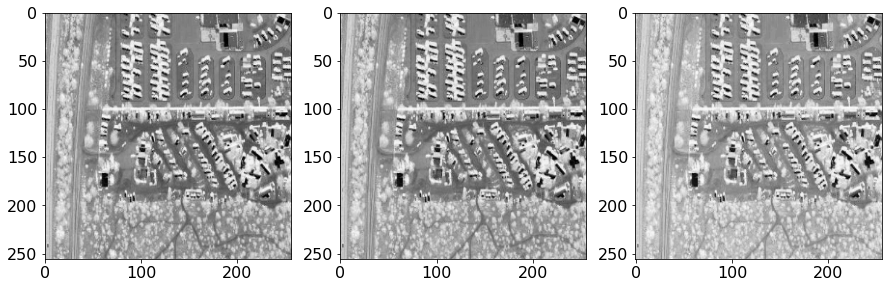

In [404]:
#original
fig, axs = plt.subplots(1, 3, figsize=(15,8))
axs[0].imshow(image_batch[0][:,:,0].numpy(), cmap='Greys')
axs[1].imshow(image_batch[0][:,:,1].numpy(), cmap='Greys')
axs[2].imshow(image_batch[0][:,:,2].numpy(), cmap='Greys')

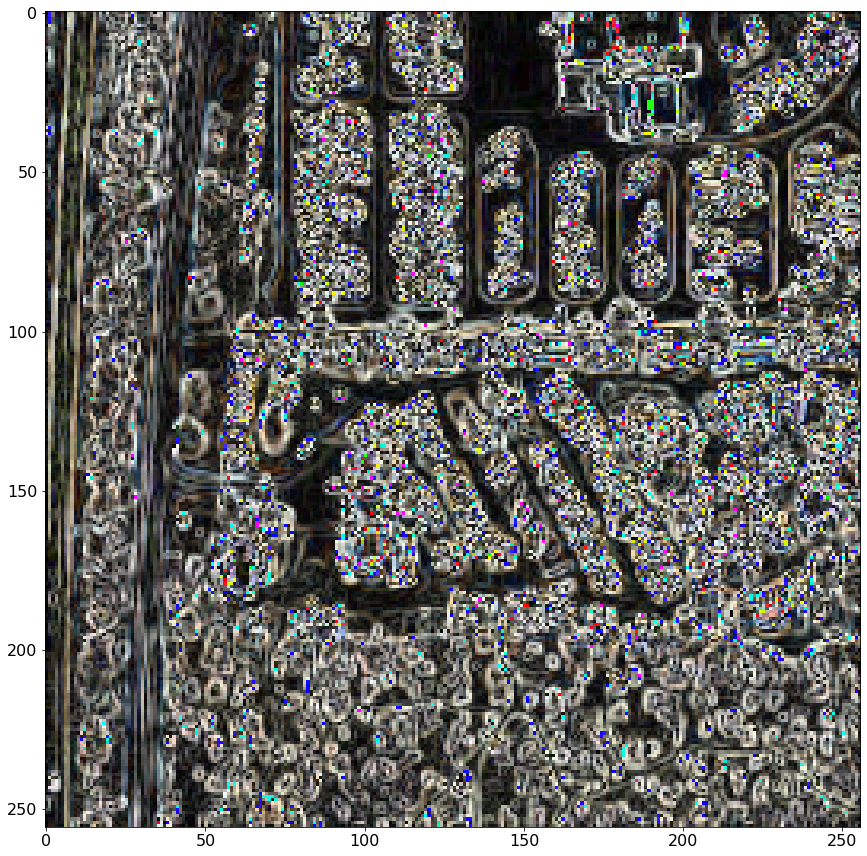

In [387]:
# but this does weird stuff with 3 channels
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(test[0].numpy().astype('uint8'), cmap='Greys')

In [367]:
# try again with tf image gradients
from tensorflow.image import image_gradients
from tensorflow.math import reduce_sum
from tensorflow import sqrt
from tensorflow import convert_to_tensor

def tf_img_gradients(image):
    '''
    test with an image dataset
    '''
    # returns tensors with same shape but with info on vert and hor grads
    dx, dy = image_gradients(image) # need to do separately for each channel?
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize (Q&D)
    # convert back to tensor
    mag_tf = convert_to_tensor(mag)
    return mag_tf

In [373]:
# for datasets
def tf_img_gradients_ds(image, label):
    '''
    '''
    # define things for tf dataset
    im_shape = image.shape
    [image,] = py_function(tf_img_gradients, [image], [float32])
    image.set_shape(im_shape)
    return image, label

In [374]:
# try it for the entire ds
X_train_grads = X_train.map(tf_img_gradients_ds)

In [375]:
X_train_grads

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

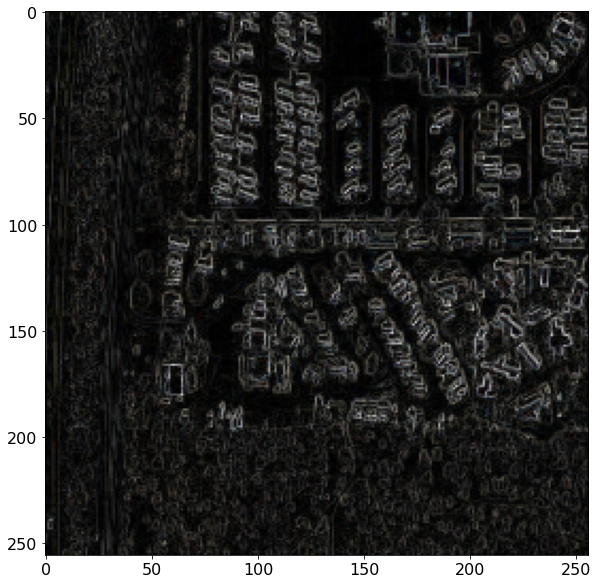

In [377]:
# plot it
image_batch_grad, labels_batch_grad = next(iter(X_train_grads))
fig, ax = plt.subplots(1, figsize=(10,10))
plt.imshow(image_batch_grad[0].numpy().astype('uint8'), cmap='Greys');

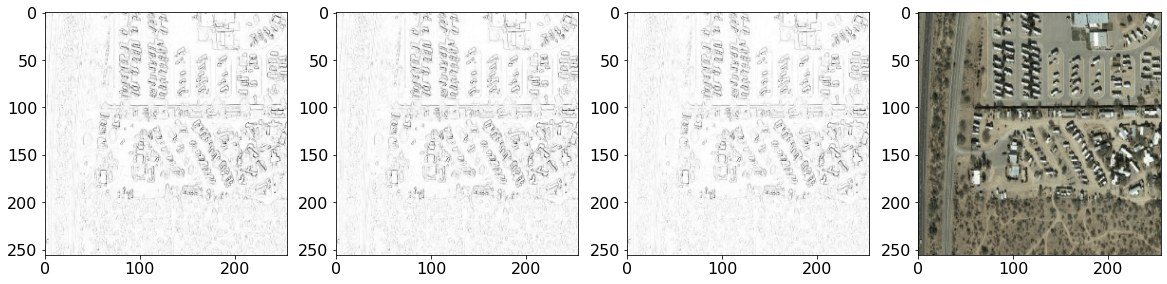

In [380]:
# each channel separately
fig, axs = plt.subplots(1, 4, figsize=(20,8))
axs[0].imshow(image_batch_grad[0,:,:,0], cmap='Greys')
axs[1].imshow(image_batch_grad[0,:,:,1], cmap='Greys')
axs[2].imshow(image_batch_grad[0,:,:,2], cmap='Greys')
axs[3].imshow(image_batch[0].numpy().astype('uint8'), cmap='Greys')

In [368]:
image_batch_grads = tf_img_gradients(image_batch)

In [369]:
image_batch_grads.shape

TensorShape([2, 256, 256, 3])

In [370]:
type(image_batch_grads)

tensorflow.python.framework.ops.EagerTensor

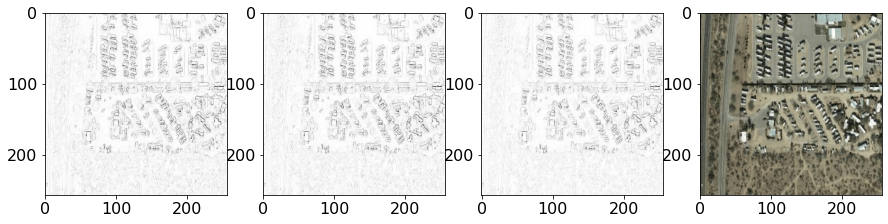

In [371]:
# fig, ax = plt.subplots(1, figsize=(15,15))
# plt.imshow(image_batch_grads[0,:,:,0], cmap='Greys')

# each channel separate - you can slice into tensor just like numpy
fig, axs = plt.subplots(1, 4, figsize=(15,8))
axs[0].imshow(image_batch_grads[0,:,:,0], cmap='Greys')
axs[1].imshow(image_batch_grads[0,:,:,1], cmap='Greys')
axs[2].imshow(image_batch_grads[0,:,:,2], cmap='Greys')
axs[3].imshow(image_batch[0].numpy().astype('uint8'), cmap='Greys')

In [309]:
dx.shape

TensorShape([2, 256, 256, 3])

In [346]:
mag = np.hypot(dx, dy)
mag *= 255.0 / np.max(mag)

In [347]:
mag.shape

(2, 256, 256, 3)

In [348]:
mag = mag[0,:,:,0] # gets first image and first channel

In [349]:
mag.shape

(256, 256)

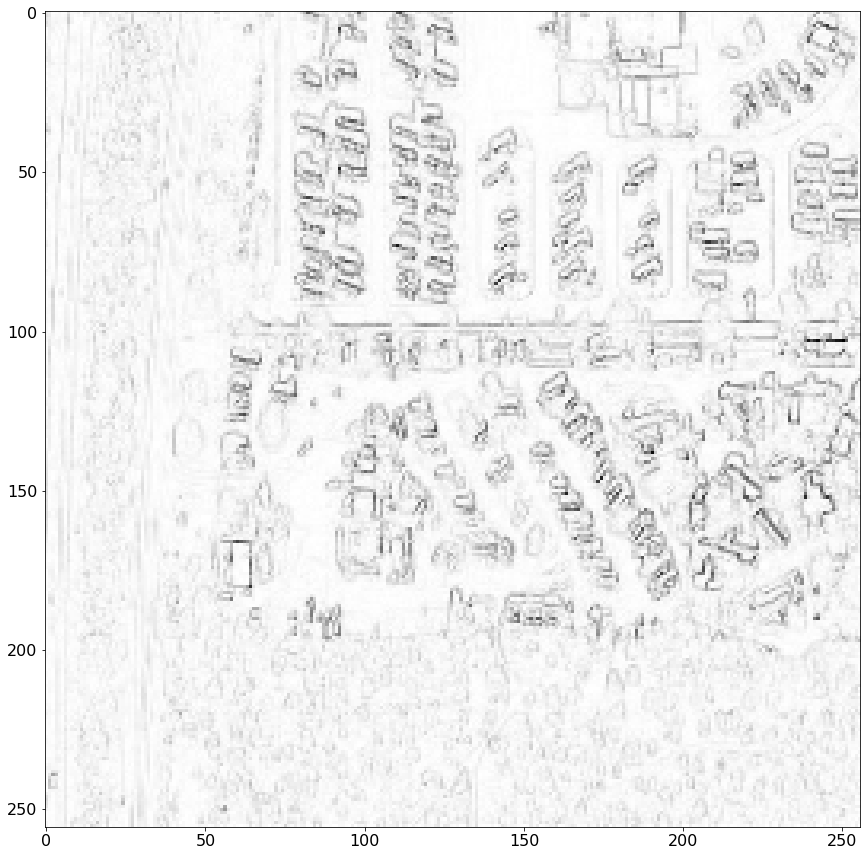

In [350]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(mag, cmap='Greys')

In [323]:
# pick one channel from first image
one_channel = dx[0]

In [302]:
# one_channel = one_channel.numpy().astype('int')

In [324]:
one_channel.shape

TensorShape([256, 256, 3])

In [325]:
one_channel = one_channel[:,:,0]

In [326]:
one_channel.shape

TensorShape([256, 256])

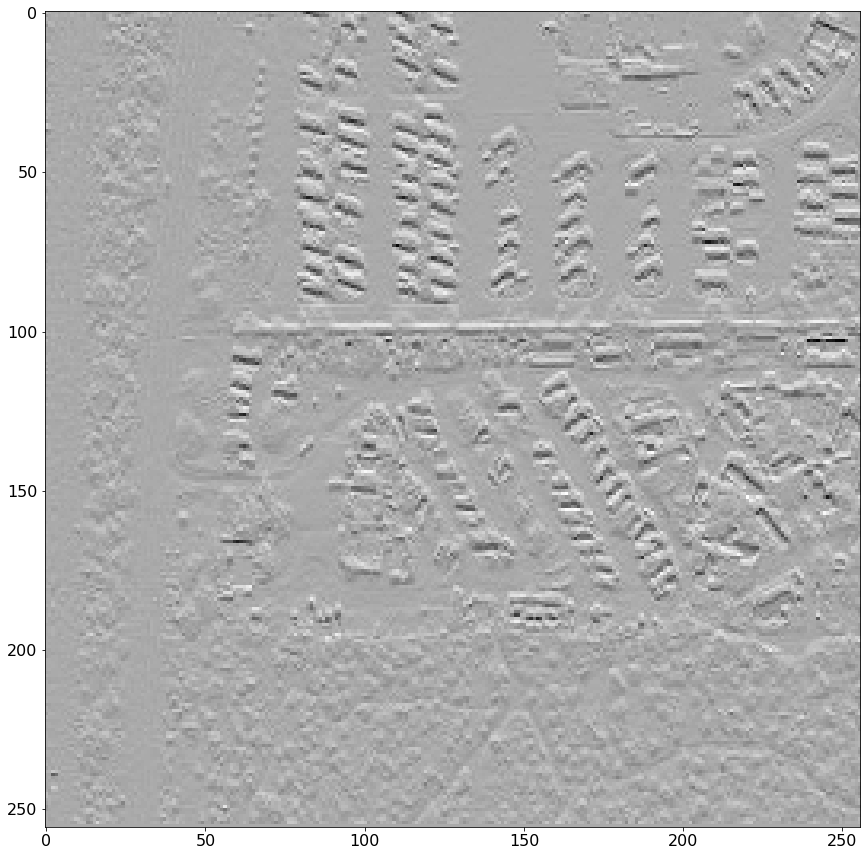

In [329]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(one_channel, cmap='Greys')

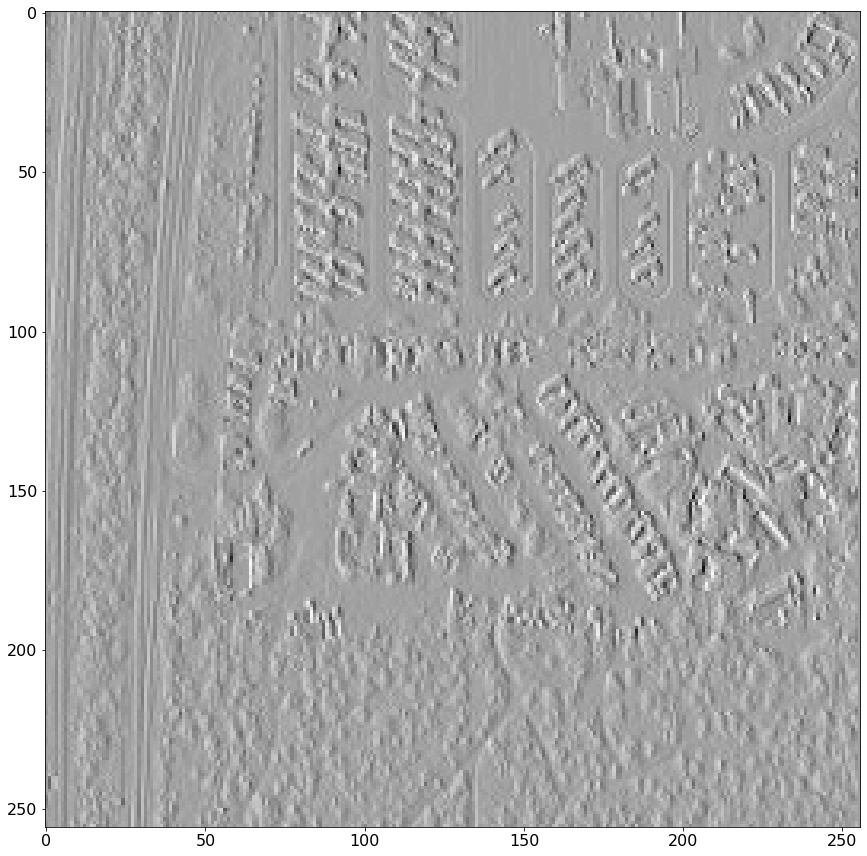

In [379]:
one_channel = dy[0]
one_channel = one_channel[:,:,0]
fig, ax = plt.subplots(1, figsize=(15,15))
plt.imshow(one_channel, cmap='Greys')